Opening the Data Sources

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
import zipfile
import sqlite3

In [2]:
movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year  


In [3]:
with zipfile.ZipFile("zippedData/im.db.zip", "r") as zObject:
        zObject.extractall()

In [4]:
conn = sqlite3.connect("im.db")
cur = conn.cursor()

In [5]:
pd.read_sql("""
SELECT *
FROM persons
;
""", conn).head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [6]:
pd.read_sql("""
SELECT genres
FROM movie_basics
GROUP BY genres
;
""", conn)

,genres
0,None
1,Action
2,"Action,Adult,Comedy"
3,"Action,Adventure"
4,"Action,Adventure,Animation"
...,...
1081,"Thriller,War,Western"
1082,"Thriller,Western"
1083,War
1084,"War,Western"


In [7]:
pd.read_sql("""
SELECT *
FROM movie_ratings
;
""", conn).head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [8]:
q = """
SELECT averagerating as avg_rating, genres
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating IS NOT NULL
AND genres IS NOT NULL
ORDER BY avg_rating desc
limit 200
;
"""
high_ratings = pd.read_sql(q, conn)
print(high_ratings)

     avg_rating                       genres
0          10.0                  Documentary
1          10.0                  Documentary
2          10.0            Crime,Documentary
3          10.0                  Documentary
4          10.0                  Documentary
..          ...                          ...
195         9.4          Documentary,Musical
196         9.4        Biography,Documentary
197         9.4            Documentary,Sport
198         9.4  Biography,Documentary,Drama
199         9.4                  Documentary

[200 rows x 2 columns]


In [15]:
high_ratings_analysis = high_ratings.groupby(by="genres", as_index=False)["avg_rating"].mean()

print(high_ratings_analysis) 

                             genres  avg_rating
0                            Action    9.700000
1         Action,Comedy,Documentary    9.400000
2                Action,Documentary    9.400000
3   Adventure,Biography,Documentary    9.600000
4                  Adventure,Comedy   10.000000
5             Adventure,Documentary    9.500000
6     Adventure,Documentary,History    9.400000
7                  Adventure,Family    9.400000
8      Animation,Documentary,Family    9.600000
9                         Biography    9.500000
10     Biography,Comedy,Documentary    9.433333
11      Biography,Crime,Documentary    9.400000
12            Biography,Documentary    9.400000
13      Biography,Documentary,Drama    9.583333
14    Biography,Documentary,History    9.400000
15      Biography,Documentary,Music    9.800000
16          Biography,Drama,History    9.600000
17                           Comedy    9.600000
18               Comedy,Documentary    9.800000
19         Comedy,Documentary,Drama    9

In [17]:
top_30 = high_ratings_analysis.iloc[:30]

print(top_30)

                             genres  avg_rating
0                            Action    9.700000
1         Action,Comedy,Documentary    9.400000
2                Action,Documentary    9.400000
3   Adventure,Biography,Documentary    9.600000
4                  Adventure,Comedy   10.000000
5             Adventure,Documentary    9.500000
6     Adventure,Documentary,History    9.400000
7                  Adventure,Family    9.400000
8      Animation,Documentary,Family    9.600000
9                         Biography    9.500000
10     Biography,Comedy,Documentary    9.433333
11      Biography,Crime,Documentary    9.400000
12            Biography,Documentary    9.400000
13      Biography,Documentary,Drama    9.583333
14    Biography,Documentary,History    9.400000
15      Biography,Documentary,Music    9.800000
16          Biography,Drama,History    9.600000
17                           Comedy    9.600000
18               Comedy,Documentary    9.800000
19         Comedy,Documentary,Drama    9

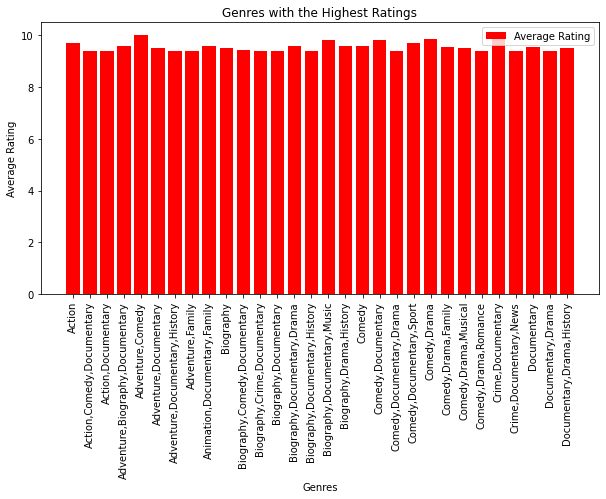

In [20]:
plt.figure(figsize=(10, 5))
plt.bar(top_30["genres"], top_30["avg_rating"], color = "r")
plt.xlabel("Genres")
plt.xticks(rotation = 90)
plt.ylabel("Average Rating")
plt.title("Genres with the Highest Ratings")
plt.legend(labels=['Average Rating'])
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

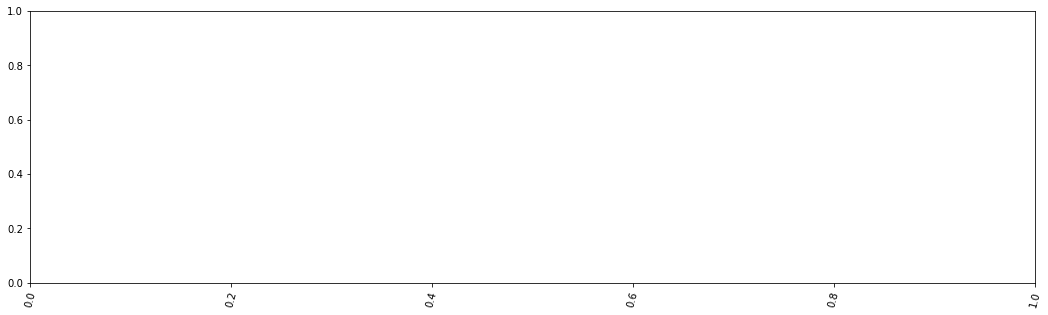

In [12]:
sql = """SELECT averagerating as avg_rating, genres
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
ORDER BY averagerating desc
LIMIT 100"""

f, ax = plt.subplots(figsize=(18,5))
plt.xticks(rotation=75)

data = pd.read_sql(sql, conn)
plt.bar(high_ratings, data.avg_rating)
plt.xlabel("Genres")
plt.ylabel("Average Rating")
plt.title("Genres with the Highest Ratings")
plt.show()

In [ ]:
q = """
SELECT averagerating as avg_rating, genres
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating IS NOT NULL
AND genres IS NOT NULL
ORDER BY avg_rating desc
limit 100
;
"""

f, ax = plt.subplots(figsize=(18,5))
plt.xticks(rotation=75)

high_ratings = pd.read_sql(sql, conn)
plt.bar(high_ratings.genres, high_ratings.avg_rating)
plt.xlabel("Genres")
plt.ylabel("Average Rating")
plt.title("Genres with the Highest Ratings")
plt.show()

In [ ]:
sql = """SELECT averagerating as avg_rating, genres
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating IS NOT NULL
AND genres IS NOT NULL
AND genres IN  ('Drama', 'Comedy', 'Action', 'Romance', 'Documentary', 'Crime', 'Thriller', 'War', 'Biography')
ORDER BY averagerating DESC
LIMIT 175"""

f, ax = plt.subplots(figsize=(18,5))
plt.xticks(rotation=75)

data = pd.read_sql(sql, conn)

plt.bar(data.genres, data.avg_rating)
plt.xlabel("Genres")
plt.ylabel("Average Rating")
plt.title("Genres with the Lowest Ratings")
plt.show()

In [ ]:

movie_popularity = pd.read_csv("zippedData/tmdb.movies.csv.gz")
print(movie_popularity)


In [ ]:
#cleaning 
movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
movie_gross_data["foreign_gross"].fillna(0, inplace = True)
movie_gross_data["domestic_gross"].fillna(0, inplace = True)
movie_gross_data.dropna(inplace = True)
print(movie_gross_data)

In [ ]:
#cleaning 
movie_gross_data["domestic_gross"].replace(',','', regex = True, inplace = True)
movie_gross_data["foreign_gross"].replace(',','', regex = True, inplace = True)


In [ ]:
movie_gross_data["total_gross"] = movie_gross_data["foreign_gross"].astype(float) + movie_gross_data["domestic_gross"].astype(float)
print(movie_gross_data)